In [1]:
import time
import numpy as np
import pickle
import os
import copy
import matplotlib.pyplot as plt
from matplotlib import pyplot
np.random.seed(400)

In [2]:
path = '/Users/user/Desktop/MSM/09-Deep Learning - KTH/assignments/assignment-1/Datasets/cifar-10-batches-py'
result_pics = '/Users/user/Desktop/MSM/09-Deep Learning - KTH/assignments/assignment-1/Result_Pics'

In [3]:
def LoadBatch(filename):
    class parse_file():
        def __init__(self, data, labels, y):
            self.data = data
            self.labels = labels
            self.y = y
    
    with open(filename, 'rb') as fo:
        dict_ = pickle.load(fo, encoding='bytes')   
    
    X = (dict_[b'data']).astype('float32')/255
    Y =np.zeros((len(dict_[b'labels']),len(np.unique(dict_[b'labels']))))   
    Y[np.arange(len(dict_[b'labels'])), dict_[b'labels']] = 1    
    y= np.array(dict_[b'labels'])    
    
    return parse_file(X,Y.transpose(), y)        

In [4]:
class params():
    def __init__(self, n_batch, eta, n_epochs):
        self.n_batch = n_batch
        self.eta = eta
        self.n_epochs = n_epochs

In [5]:
def ComputeAccuracy(X_, y_, W_, b_):
    P_ = np.argmax(EvaluateClassifier(X_, W_ ,b_),axis=1)
    acc = np.count_nonzero(y_== P_) / float(len(P_))
    return acc

In [6]:
def EvaluateClassifier(X_, W_, b_):
    """
    EvaluateClassifier is a function that computes the SOFTMAX, complete the forward pass.
    """
    s = np.matmul(X_, W_.transpose()) + b_.transpose()
    exp_s = np.exp(s)
    exp_sum = np.sum(exp_s, axis=1)
    P = exp_s.transpose() / exp_sum 
    
    return P.transpose()

In [7]:
def ComputeCost(X_, Y_, W_, b_, lambda_=0):
    Npts = X_.shape[0] if len(X_.shape) == 2 else 1
    P_ = EvaluateClassifier(X_, W_, b_)
    
    l_cross = -np.log(np.sum(np.multiply(Y_, P_),axis=1))
    J = np.sum(l_cross)/Npts + lambda_*np.linalg.norm(W_)
    return J

In [8]:
def ComputeGradients(X_, Y_, P_, W_, b_, lambda_=0):
    """
    ComputeGradients is a function that computes the analytic gradient.
    :return grad_W: is the gradient matrix of the cost J relative to W and has size Kxd
    :return grad_b: is the gradient vector of the cost J relative to b and has size Kx1
    """
    X_ = X_ if len(X_.shape) == 2 else X_.reshape(1, -1)
      
    Npts_, k_  = Y_.shape if len(Y_.shape) == 2 else (1, Y_.shape[0])

    d_ = X_.shape[-1]
    
    #initialize gradients at zero:
    grad_W = np.zeros((k_,d_))
    grad_b = np.zeros((k_,1))
    
    # G_batch:
    G_ = -(Y_ - P_)
    
    #compute gradients of the cost L:
    grad_W_L = np.matmul(G_.transpose(), X_) / float(Npts_)
    grad_b_L = np.sum(G_,axis=0) / float(Npts_) 
    
    #update gradients of the cost J:
    grad_W = grad_W_L + 2*(np.multiply(lambda_, W_))
    grad_b = grad_b_L

    return grad_W, grad_b.reshape(-1,1)

In [9]:
def ComputeGradsNum(X_, Y_, W_, b_, h_=1e-6, lambda_=0):
    """
    ComputeGradsNum is a function that computes the numerical gradient 
    using finite difference method.
    """
    no = W_.shape[0]
    d = W_.shape[1] 

    grad_W = np.zeros((no,d))
    grad_b = np.zeros((no,1))

    c = ComputeCost(X_, Y_, W_, b_, lambda_)

    for i in range(len(b_)):
        b_try = copy.deepcopy(b_)
        b_try[i] = b_try[i] + h_
        c2 = ComputeCost(X_, Y_, W_, b_try, lambda_)
        grad_b[i] = (c2-c) / h_

    for i in range(no):
        for j in range(d):
            W_try = copy.deepcopy(W_)
            W_try[i][j] = W_try[i][j] + h_
            c2 = ComputeCost(X_, Y_, W_try, b_, lambda_)
            grad_W[i][j] = (c2-c) / h_

    return grad_W, grad_b 

In [10]:
def ComputeGradsNumSlow(X_, Y_, W_, b_, lambda_=0,h_=1e-6):
    """
    ComputeGradsNumSlow is a function that computes the numerical gradient 
    using the Centered difference formula
    """
    no = W_.shape[0]
    d = W_.shape[1] 

    grad_W = np.zeros((no,d))
    grad_b = np.zeros((no,1))
    
    for i in range(len(b_)):
        b_try = copy.deepcopy(b_)
        b_try[i] = b_try[i] - h_
        c1 = ComputeCost(X_, Y_, W_, b_try, lambda_)
        b_try = copy.deepcopy(b_)
        b_try[i] = b_try[i] + h_
        c2 = ComputeCost(X_, Y_, W_, b_try, lambda_)
        grad_b[i] = (c2-c1) / (2*h_)

    for i in range(no):
        for j in range(d):
            W_try = copy.deepcopy(W_)
            W_try[i][j] = W_try[i][j] - h_
            c1 = ComputeCost(X_, Y_, W_try, b_, lambda_)
            W_try =copy.deepcopy(W_)
            W_try[i][j] = W_try[i][j] + h_
            c2 = ComputeCost(X_, Y_, W_try, b_, lambda_)
            grad_W[i][j]= (c2-c1) / (2*h_)

    return grad_W, grad_b

In [11]:
def MaxRelativeError(g_a, g_n):
    """
    :returns max_relative_error: highest relative error among all gradients.
    """
    max_value = np.zeros(g_a.shape)
    eps = np.finfo(np.float32).eps
    absolute_v = np.absolute(g_a) + np.absolute(g_n)
    
    for i in range(g_a.shape[0]):
        for j in range(g_a.shape[1]):
            max_value[i][j] = max(eps, absolute_v[i][j])
    
    max_relative_error = np.amax(np.absolute(g_a-g_n) / max_value)
    
    return max_relative_error

In [12]:
def w_b_random_initiation(X_, Y_, mu, sigma):
    no = Y_.shape[0]
    d = X_.shape[1]
    Npts = X_.shape[0]
    W_ = np.random.normal(mu, sigma, (no, d))
    b_ = np.random.normal(mu, sigma, (no,1))
    
    return W_, b_

In [13]:
def unison_shuffled_copies(X_, Y_):
    """
    """
    assert len(X_) == len(Y_)
    p = np.random.permutation(len(X_))
    return X_[p], Y_[p]

In [57]:
def MiniBatchGD_eta_decay(X_, X_val, Y_, y_, Y_val, y_val, GD_params, lambda_=0):
    """
    :param X_: trainning images.
    :param Y_: Labels for the trainning images
    :param GDparams: object containing the parameter values:
        *'n_batch': size of the mini batch
        *'eta': learning rate and 
        *'n_epochs': number of runs through the whole trainning set. 
    :param lambda_: regularization factor in the cost function.
    :return Wstar:
    :return bstar:
    """
    Npts = X_.shape[0]
    cf_train = []
    cf_val = []
    cl_train = []
    cl_val = []
    acc_train = []
    acc_val = []
    k = 5
    W_, b_ = w_b_random_initiation(X_, Y_, mu, sigma)
    
    for epoch in range(GD_params.n_epochs):
        
        if epoch % k == 0:
            GD_params.eta == GD_params.eta / 2 # - (GD_params.eta * 10)
            
        for j in range(Npts//GD_params.n_batch):
            j_start = j * GD_params.n_batch
            j_end = (j + 1) * GD_params.n_batch
            Xbatch = X_[j_start:j_end]
            Ybatch = Y_[:, j_start:j_end].transpose()

            P_ = EvaluateClassifier(Xbatch, W_, b_)
            grad_w, grad_b = ComputeGradients(Xbatch, Ybatch, P_, W_, b_, lambda_)

            W_ = W_ - GD_params.eta*grad_w
            b_ = b_ - GD_params.eta* grad_b
                
        # cost per epoch
        trainning_cost = ComputeCost(X_, Y_.transpose(), W_, b_, lambda_)
        validation_cost = ComputeCost(X_val, Y_val.transpose(), W_, b_, lambda_)
        
        # loss per epoch
        trainning_loss = ComputeCost(X_, Y_.transpose(), W_, b_, 0)
        validation_loss = ComputeCost(X_val, Y_val.transpose(), W_, b_, 0)
        
        cf_train.append(trainning_cost)
        cf_val.append(validation_cost)
        
        cl_train.append(trainning_loss)
        cl_val.append(validation_loss)
        
        # accuracy per epoch
        acc_train_ = ComputeAccuracy(X_, y_, W_, b_)
        acc_val_ = ComputeAccuracy(X_val, y_val, W_, b_)
        
        acc_train.append(acc_train_)
        acc_val.append(acc_val_)
         
    return W_, b_, cf_train, cf_val, cl_train, cl_val, acc_train, acc_val

In [58]:
def MiniBatchGD(X_, X_val, Y_, y_, Y_val, y_val, GD_params, lambda_=0):
    """
    :param X_: trainning images.
    :param Y_: Labels for the trainning images
    :param GDparams: object containing the parameter values:
        *'n_batch': size of the mini batch
        *'eta': learning rate and 
        *'n_epochs': number of runs through the whole trainning set. 
    :param lambda_: regularization factor in the cost function.
    :return Wstar:
    :return bstar:
    """
    Npts = X_.shape[0]
    cf_train = []
    cf_val = []
    cl_train = []
    cl_val = []
    acc_train = []
    acc_val = []
    
    W_, b_ = w_b_random_initiation(X_, Y_, mu, sigma)
    
    for epoch in range(GD_params.n_epochs):
        for j in range(Npts//GD_params.n_batch):
            j_start = j * GD_params.n_batch
            j_end = (j + 1) * GD_params.n_batch
            Xbatch = X_[j_start:j_end]
            Ybatch = Y_[:, j_start:j_end].transpose()

            P_ = EvaluateClassifier(Xbatch, W_, b_)
            grad_w, grad_b = ComputeGradients(Xbatch, Ybatch, P_, W_, b_, lambda_)

            W_ = W_ - GD_params.eta*grad_w
            b_ = b_ - GD_params.eta* grad_b
                
        # cost per epoch
        trainning_cost = ComputeCost(X_, Y_.transpose(), W_, b_, lambda_)
        validation_cost = ComputeCost(X_val, Y_val.transpose(), W_, b_, lambda_)
        
        # loss per epoch
        trainning_loss = ComputeCost(X_, Y_.transpose(), W_, b_, 0)
        validation_loss = ComputeCost(X_val, Y_val.transpose(), W_, b_, 0)
        
        cf_train.append(trainning_cost)
        cf_val.append(validation_cost)
        
        cl_train.append(trainning_loss)
        cl_val.append(validation_loss)
        
        # accuracy per epoch
        acc_train_ = ComputeAccuracy(X_, y_, W_, b_)
        acc_val_ = ComputeAccuracy(X_val, y_val, W_, b_)
        
        acc_train.append(acc_train_)
        acc_val.append(acc_val_)
         
    return W_, b_, cf_train, cf_val, cl_train, cl_val, acc_train, acc_val

In [59]:
def MiniBatchGD_shuffled(X_, X_val, Y_, y_, Y_val, y_val, GD_params, lambda_=0):
    """
    :param X_: trainning images.
    :param Y_: Labels for the trainning images
    :param GDparams: object containing the parameter values:
        *'n_batch': size of the mini batch
        *'eta': learning rate and 
        *'n_epochs': number of runs through the whole trainning set. 
    :param lambda_: regularization factor in the cost function.
    :return Wstar:
    :return bstar:
    """
    Npts = X_.shape[0]
    cf_train = []
    cf_val = []
    cl_train = []
    cl_val = []
    acc_train = []
    acc_val = []
    W_, b_ = w_b_random_initiation(X_, Y_, mu, sigma)
    for epoch in range(GD_params.n_epochs):
        shuffle_x, shuffle_y = unison_shuffled_copies(X_, Y_.transpose())
        shuffle_y = shuffle_y.transpose()
        
        for j in range(Npts//GD_params.n_batch):
            j_start = j * GD_params.n_batch
            j_end = (j + 1) * GD_params.n_batch
            Xbatch = shuffle_x[j_start:j_end]
            Ybatch = shuffle_y[:, j_start:j_end].transpose()

            P_ = EvaluateClassifier(Xbatch, W_, b_)
            grad_w, grad_b = ComputeGradients(Xbatch, Ybatch, P_, W_, b_, lambda_)

            W_ = W_ - GD_params.eta*grad_w
            b_ = b_ - GD_params.eta* grad_b
                
        # cost per epoch
        trainning_cost = ComputeCost(X_, Y_.transpose(), W_, b_, lambda_)
        validation_cost = ComputeCost(X_val, Y_val.transpose(), W_, b_, lambda_)
        
        # loss per epoch
        trainning_loss = ComputeCost(X_, Y_.transpose(), W_, b_, 0)
        validation_loss = ComputeCost(X_val, Y_val.transpose(), W_, b_, 0)
        
        cf_train.append(trainning_cost)
        cf_val.append(validation_cost)
        
        cl_train.append(trainning_loss)
        cl_val.append(validation_loss)
        
        # accuracy per epoch
        acc_train_ = ComputeAccuracy(X_, y_, W_, b_)
        acc_val_ = ComputeAccuracy(X_val, y_val, W_, b_)
        
        acc_train.append(acc_train_)
        acc_val.append(acc_val_)
        
        
    return W_, b_, cf_train, cf_val, cl_train, cl_val, acc_train, acc_val

In [116]:
def plot_validation_trainning_cf_acc(
                                    validation_list_cf_,
                                    trainning_list_cf_,
                                    acc_train_,
                                    acc_val_,
                                    cl_train_,
                                    cl_val_,
                                    GD_params_,
                                    lambda_,
                                    out_filename='none'
                                    ):

    t=range(len(validation_list_cf_))
    pyplot.figure(figsize=(13,5))
    pyplot.subplots_adjust(wspace=0.3)
    pyplot.suptitle(f'batch_n = {GD_params_.n_batch}, eta = {GD_params_.eta},lambda = {lambda_}', size =16)
    pyplot.style.use('seaborn-darkgrid')
    # sp1
    pyplot.subplot(131)
    pyplot.plot(t, validation_list_cf_, '#4363d8', label = 'validation loss') 
    pyplot.plot(t, trainning_list_cf_, '#3cb44b', label = 'trainning loss') 
    pyplot.legend(loc='best')
    pyplot.xlabel('epoch', size = 13.5)
    pyplot.ylabel('Cost', size = 13.5)
    pyplot.title('Cost',size = 14)
    # sp2
    pyplot.subplot(132)
    pyplot.plot(t, cl_val_, '#4363d8', label = 'validation cost') 
    pyplot.plot(t, cl_train_, '#3cb44b', label = 'trainning cost') 
    pyplot.legend(loc='best')
    pyplot.xlabel('epoch', size = 13.5)
    pyplot.ylabel('Loss', size = 13.5)
    pyplot.title('Loss', size = 14)
    # sp3
    pyplot.subplot(133)
    pyplot.plot(acc_train_,'#4363d8',  label= 'trainning acc')
    pyplot.plot(acc_val_, '#3cb44b', label = 'validation acc')
    pyplot.legend(loc='best')
    pyplot.xlabel('epoch', size = 13.5)
    pyplot.ylabel('Accuracy', size = 13.5)
    pyplot.title('Accuracy', size = 14)
    if out_filename=='none':
        pyplot.show()
    else:
        pyplot.savefig(out_filename)
        pyplot.show()  

In [53]:
def display_class_template_image(W_star_,out_filename='none' ):
    fig, axarr = plt.subplots(nrows=1, ncols=10, figsize=(20, 20))
    for i, arr in zip((range(len(W_star_))), axarr):
        image = W_star_[i].reshape(3, 32,32)
        s_im = ((image - image.min()) / (image.max() - image.min())).astype('float32')
        s_im = np.transpose(s_im, (1, 2, 0))
        arr.axis('off')
        arr.grid(b=None)
        arr.imshow(s_im)
    if out_filename=='none':
        plt.show() 
    else:
        plt.savefig(out_filename)
        plt.show()  

In [60]:
def grid_search(trainning_data, validation_data, nb_batchs_and_epochs, lambda_list,eta_list):
    result_list = []
    mu, sigma = 0, 0.01
    for nb_batch, nb_epoch in reversed(nb_batchs_and_epochs):
        for lambda_ in lambda_list:
            for eta in eta_list:
                GD_params = params(nb_batch, eta, nb_epoch)
                tic = time.time()
                print('start training for parameters:')
                print(f'nb_batch: {nb_batch} nb_epoch:{nb_epoch}')
                print(f'lambda_: {lambda_} eta:{eta}')

                W_star, b_star, cf_train, cf_val, cl_train, cl_val, acc_train, acc_val = MiniBatchGD(
                    trainning_data.data, validation_data.data, trainning_data.labels, trainning_data.y,
                    validation_data.labels, validation_data.y,
                    GD_params, lambda_=lambda_
                )
                tac = time.time()
                print(f'training with these parameters took {tac - tic} seconds')

                min_val_cf, corresponding_acc = min(
                        [cf_and_acc for cf_and_acc in zip(cf_val, acc_val)],
                        key=lambda x: x[0]
                    )
                print(
                    f'training ended with minimum validation cost: {min_val_cf} and '
                    f' corresponding accuracy: {100 * corresponding_acc} %'
                )
                print(' ')
                print(' ')

                result_list.append(
                    [W_star, b_star, cf_train, cf_val, cl_train, cl_val, acc_train, acc_val, GD_params, lambda_]
                )
                
    return result_list




In [20]:
#Load Data:
trainning_data = LoadBatch(os.path.join(path,'data_batch_1'))
validation_data = LoadBatch(os.path.join(path,'data_batch_2'))
test_data = LoadBatch(os.path.join(path,'test_batch'))
mu, sigma = 0, 0.01

In [21]:
#Check Gradient Computations: Analytic and Numerical Estimations:
test_vector = trainning_data.data[0]
test_labels = trainning_data.labels.transpose()[0]
W = np.random.normal(mu, sigma, (test_labels.shape[0], test_vector.shape[0]))
b = np.random.normal(mu, sigma, (test_labels.shape[0],1))
P_vec = EvaluateClassifier(test_vector, W, b)

#Analytic Gradient Computations:
test_grad_W, test_grad_b = ComputeGradients(test_vector, test_labels, P_vec, W, b, 0)

#Numerical estimations of the gradients:

#Finite difference method:
test_grad_W_, test_grad_b_ = ComputeGradsNum(test_vector, test_labels, W, b)

#Using Centered difference formula:
slow_test_grad_W_, slow_test_grad_b_ = ComputeGradsNumSlow(test_vector, test_labels, W, b)
#Reduced dimensionality version of the input:
slow_test_grad_W_reduced, slow_test_grad_b_reduced = ComputeGradsNumSlow(test_vector[0:20], test_labels, W[:, 0:20], b)


In [22]:
#Verify Maximum Relative Error between Analitic and Numerical Gradient Computations:
print(MaxRelativeError(test_grad_W, test_grad_W_))
print(MaxRelativeError(test_grad_W, slow_test_grad_W_))
print(MaxRelativeError(test_grad_b, test_grad_b_))
print(MaxRelativeError(test_grad_b, slow_test_grad_b_))

2.3300099931579816e-07
7.211479551922645e-08
2.3300099931579816e-07
1.326865359264574e-09


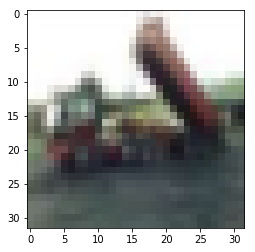

In [23]:
# Testing image sample visualization.
plt.imshow((trainning_data.data[2,:]).reshape(3,32,32).transpose(1,2,0))
plt.show()

In [24]:
W, b = w_b_random_initiation(trainning_data.data, trainning_data.labels, mu, sigma)

In [118]:
GD_params_a = params(100, 0.1, 40)
(W_star_a, b_star_a, cf_train_a, cf_val_a, 
 cl_train_a, cl_val_a, acc_train_a, acc_val_a) = MiniBatchGD(trainning_data.data,
                                                            validation_data.data,
                                                            trainning_data.labels,
                                                            trainning_data.y,
                                                            validation_data.labels,
                                                            validation_data.y,
                                                            GD_params_a)

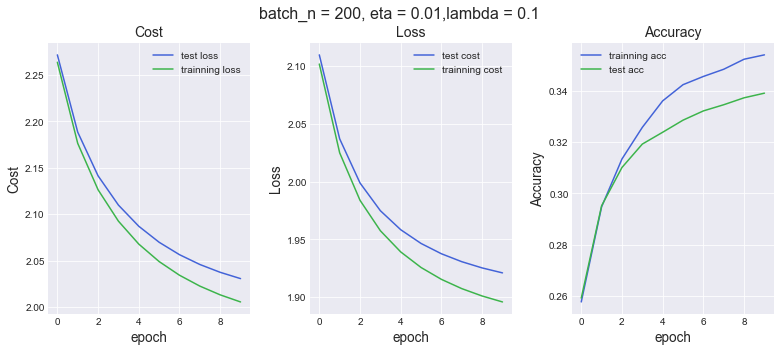

In [113]:
plot_validation_trainning_cf_acc(cf_val_a, cf_train_a, acc_train_a, acc_val_a, 
                                 cl_train_a, cl_val_a, GD_params_a,lambda_=0.1,
                                 out_filename=os.path.join(result_pics,'test1'))


In [111]:
GD_params_a = params(200, 0.01, 10)
(W_star_a, b_star_a, cf_train_a,  cf_val_a, 
 cl_train_a, cl_val_a, acc_train_a, acc_val_a) = MiniBatchGD(trainning_data.data,
                                                            test_data.data,
                                                            trainning_data.labels,
                                                            trainning_data.y,
                                                            test_data.labels,
                                                            test_data.y,
                                                            GD_params_a, lambda_=0.1)


In [101]:
print(max(acc_train_a))
print(max(acc_val_a))

0.3552
0.3378


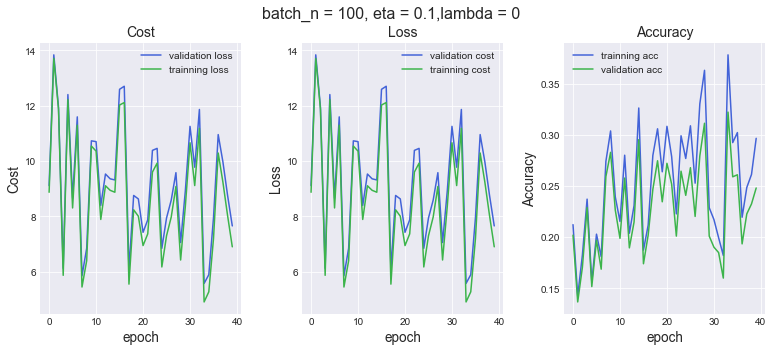

In [119]:
plot_validation_trainning_cf_acc(cf_val_a, cf_train_a, acc_train_a, acc_val_a, 
                                 cl_train_a, cl_val_a, GD_params_a,lambda_=0,
                                 out_filename=os.path.join(result_pics,'lamda_0_eta_01'))

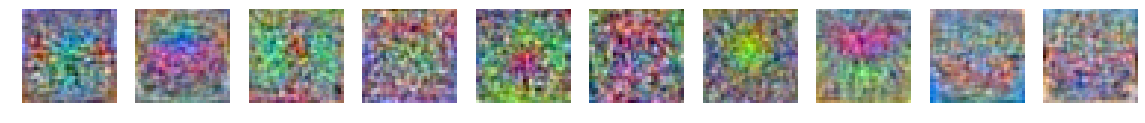

In [120]:
display_class_template_image(W_star_a, out_filename=os.path.join(result_pics,'lamda_0_eta_01_ct'))

In [75]:
GD_params_b = params(100, 0.01, 40)
(W_star_b, b_star_b, cf_train_b, cf_val_b, 
 cl_train_b, cl_val_b, acc_train_b, acc_val_b) = MiniBatchGD(trainning_data.data,
                                                            validation_data.data,
                                                            trainning_data.labels,
                                                            trainning_data.y,
                                                            validation_data.labels,
                                                            validation_data.y,
                                                            GD_params_b)

In [78]:
print(max(acc_train_b))
print(max(acc_val_b))

0.4152
0.3635


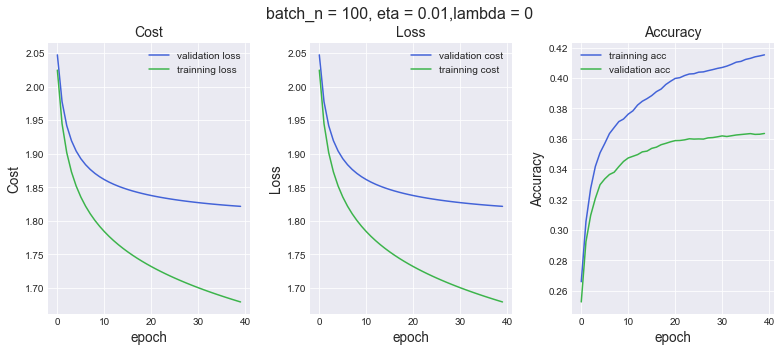

In [121]:
plot_validation_trainning_cf_acc(cf_val_b, cf_train_b, acc_train_b, acc_val_b, cl_train_b, cl_val_b, GD_params_b,lambda_=0,
                                 out_filename=os.path.join(result_pics,'lamda_0_eta_001'))

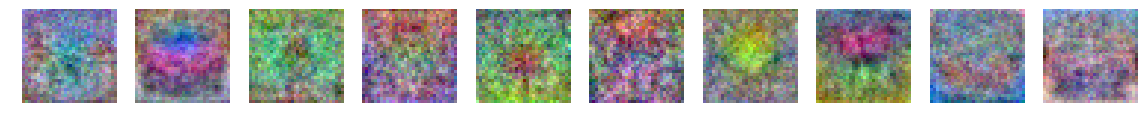

In [122]:
display_class_template_image(W_star_b, out_filename=os.path.join(result_pics,'lamda_0_eta_001_ct'))

In [86]:
GD_params_c = params(100, 0.01, 40)
(W_star_c, b_star_c, cf_train_c, cf_val_c, 
 cl_train_c, cl_val_c, acc_train_c, acc_val_c) = MiniBatchGD(trainning_data.data,
                                                            validation_data.data,
                                                            trainning_data.labels,
                                                            trainning_data.y,
                                                            validation_data.labels,
                                                            validation_data.y,
                                                            GD_params_c,
                                                            lambda_=0.1
                                                            )

In [87]:
print(max(acc_train_c))
print(max(acc_val_c))

0.342
0.3206


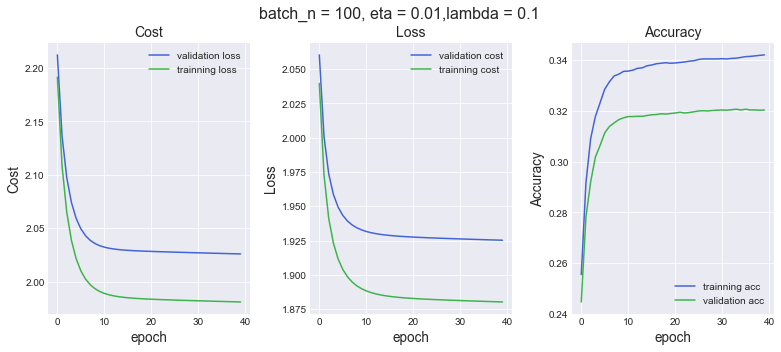

In [123]:
plot_validation_trainning_cf_acc(cf_val_c, cf_train_c, acc_train_c, acc_val_c, 
                                 cl_train_c, cl_val_c, GD_params_c,lambda_=0.1,
                                 out_filename=os.path.join(result_pics,'lamda_01_eta_001'))


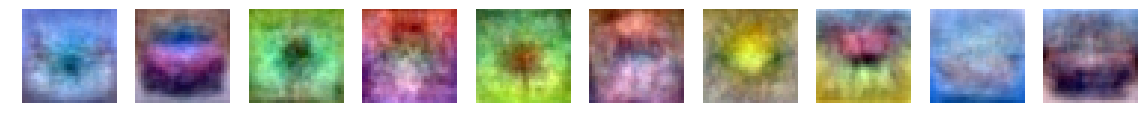

In [124]:
display_class_template_image(W_star_c, out_filename=os.path.join(result_pics,'lamda_01_eta_001_ct'))

In [89]:
GD_params_d = params(100, 0.01, 40)
(W_star_d, b_star_d, cf_train_d, cf_val_d, 
 cl_train_d, cl_val_d, acc_train_d, acc_val_d) = MiniBatchGD(trainning_data.data,
                                                            validation_data.data,
                                                            trainning_data.labels,
                                                            trainning_data.y,
                                                            validation_data.labels,
                                                            validation_data.y,
                                                            GD_params_d,
                                                            lambda_=1
                                                            )

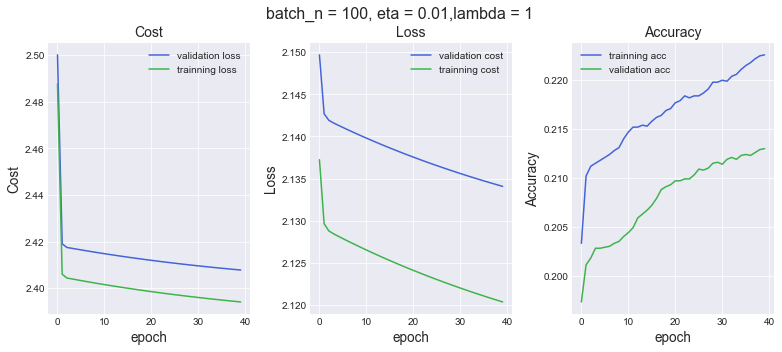

In [125]:
plot_validation_trainning_cf_acc(cf_val_d, cf_train_d, acc_train_d, acc_val_d, 
                                 cl_train_d, cl_val_d, GD_params_d,lambda_=1,
                                 out_filename=os.path.join(result_pics,'lamda_1_eta_001') )

In [91]:
print(max(acc_train_d))
print(max(acc_val_d))

0.2226
0.213


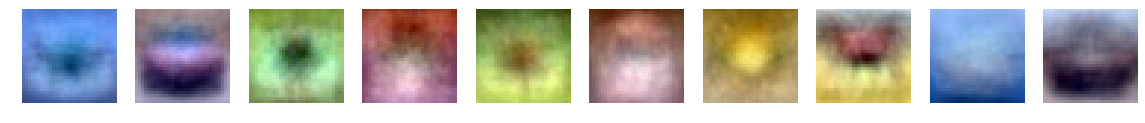

In [126]:
display_class_template_image(W_star_d, out_filename=os.path.join(result_pics,'lamda_1_eta_001_ct'))

In [46]:
#grid_search
#nb_batchs_and_epochs = [(10, 50), (50, 70), (100, 100), (200, 200)]
nb_batchs_and_epochs = [(10, 200), (50, 200)]
# lambda_list = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
lambda_list = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0]
#eta_list = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
eta_list = [1e-4, 1e-3, 1e-2]

In [40]:
result_list = []
mu, sigma = 0, 0.01
for nb_batch, nb_epoch in reversed(nb_batchs_and_epochs):
    for lambda_ in lambda_list:
        for eta in eta_list:
            GD_params = params(nb_batch, eta, nb_epoch)
            tic = time.time()
            print('start training for parameters:')
            print(f'nb_batch: {nb_batch} nb_epoch:{nb_epoch}')
            print(f'lambda_: {lambda_} eta:{eta}')
            
            W_star, b_star, cf_train, cf_val, acc_train, acc_val = MiniBatchGD(
                trainning_data.data, validation_data.data, trainning_data.labels, trainning_data.y,
                validation_data.labels, validation_data.y,
                GD_params, lambda_=lambda_
            )
            tac = time.time()
            print(f'training with these parameters took {tac - tic} seconds')
            
            min_val_cf, corresponding_acc = min(
                    [cf_and_acc for cf_and_acc in zip(cf_val, acc_val)],
                    key=lambda x: x[0]
                )
            print(
                f'training ended with minimum validation cost: {min_val_cf} and '
                f' corresponding accuracy: {100 * corresponding_acc} %'
            )
            print(' ')
            print(' ')
            
            result_list.append([W_star, b_star, cf_train, cf_val, acc_train, acc_val, GD_params])
            
            

start training for parameters:
nb_batch: 200 nb_epoch:200
lambda_: 1e-05 eta:1e-05
training with these parameters took 207.8554811477661 seconds
training ended with minimum validation cost: 2.2428499084689832 and  corresponding accuracy: 17.919999999999998 %
 
 
start training for parameters:
nb_batch: 200 nb_epoch:200
lambda_: 1e-05 eta:0.0001
training with these parameters took 190.6662847995758 seconds
training ended with minimum validation cost: 2.0208623621166497 and  corresponding accuracy: 30.84 %
 
 
start training for parameters:
nb_batch: 200 nb_epoch:200
lambda_: 1e-05 eta:0.001
training with these parameters took 190.7686779499054 seconds
training ended with minimum validation cost: 1.8384160737308655 and  corresponding accuracy: 36.9 %
 
 
start training for parameters:
nb_batch: 200 nb_epoch:200
lambda_: 1e-05 eta:0.01
training with these parameters took 246.73237895965576 seconds
training ended with minimum validation cost: 1.793803020232888 and  corresponding accuracy: 

training with these parameters took 89.5160481929779 seconds
training ended with minimum validation cost: 1.8130285856479746 and  corresponding accuracy: 37.19 %
 
 
start training for parameters:
nb_batch: 100 nb_epoch:100
lambda_: 1e-05 eta:0.1
training with these parameters took 97.37263011932373 seconds
training ended with minimum validation cost: 4.297703166730846 and  corresponding accuracy: 31.419999999999998 %
 
 
start training for parameters:
nb_batch: 100 nb_epoch:100
lambda_: 0.0001 eta:1e-05
training with these parameters took 105.81892681121826 seconds
training ended with minimum validation cost: 2.2331821357692068 and  corresponding accuracy: 19.81 %
 
 
start training for parameters:
nb_batch: 100 nb_epoch:100
lambda_: 0.0001 eta:0.0001
training with these parameters took 100.38301277160645 seconds
training ended with minimum validation cost: 2.020745637919586 and  corresponding accuracy: 30.620000000000005 %
 
 
start training for parameters:
nb_batch: 100 nb_epoch:100

training with these parameters took 67.0334939956665 seconds
training ended with minimum validation cost: 1.987498657153292 and  corresponding accuracy: 31.65 %
 
 
start training for parameters:
nb_batch: 50 nb_epoch:70
lambda_: 0.0001 eta:0.001
training with these parameters took 67.68940114974976 seconds
training ended with minimum validation cost: 1.8247212271467124 and  corresponding accuracy: 37.25 %
 
 
start training for parameters:
nb_batch: 50 nb_epoch:70
lambda_: 0.0001 eta:0.01
training with these parameters took 70.1510100364685 seconds
training ended with minimum validation cost: 1.8132359725396916 and  corresponding accuracy: 37.2 %
 
 
start training for parameters:
nb_batch: 50 nb_epoch:70
lambda_: 0.0001 eta:0.1
training with these parameters took 65.10203123092651 seconds
training ended with minimum validation cost: 5.3260895118576785 and  corresponding accuracy: 30.75 %
 
 
start training for parameters:
nb_batch: 50 nb_epoch:70
lambda_: 0.001 eta:1e-05
training wit

training with these parameters took 57.019004106521606 seconds
training ended with minimum validation cost: 10.328586029046203 and  corresponding accuracy: 26.99 %
 
 
start training for parameters:
nb_batch: 10 nb_epoch:50
lambda_: 0.001 eta:1e-05
training with these parameters took 57.249128341674805 seconds
training ended with minimum validation cost: 2.0942304579986524 and  corresponding accuracy: 29.21 %
 
 
start training for parameters:
nb_batch: 10 nb_epoch:50
lambda_: 0.001 eta:0.0001
training with these parameters took 57.24600601196289 seconds
training ended with minimum validation cost: 1.8799882647537447 and  corresponding accuracy: 35.49 %
 
 
start training for parameters:
nb_batch: 10 nb_epoch:50
lambda_: 0.001 eta:0.001
training with these parameters took 57.24837827682495 seconds
training ended with minimum validation cost: 1.8070425795691811 and  corresponding accuracy: 37.580000000000005 %
 
 
start training for parameters:
nb_batch: 10 nb_epoch:50
lambda_: 0.001 et

In [45]:
result_list_shuffled = []
mu, sigma = 0, 0.01
for nb_batch, nb_epoch in reversed(nb_batchs_and_epochs):
    for lambda_ in lambda_list:
        for eta in eta_list:
            GD_params = params(nb_batch, eta, nb_epoch)
            tic = time.time()
            print('start training for parameters:')
            print(f'nb_batch: {nb_batch} nb_epoch:{nb_epoch}')
            print(f'lambda_: {lambda_} eta:{eta}')
            
            W_star, b_star, cf_train, cf_val, acc_train, acc_val = MiniBatchGD_shuffled(
                trainning_data.data, validation_data.data, trainning_data.labels, trainning_data.y,
                validation_data.labels, validation_data.y,
                GD_params, lambda_=lambda_
            )
            tac = time.time()
            print(f'training with these parameters took {tac - tic} seconds')
            
            min_val_cf, corresponding_acc = min(
                    [cf_and_acc for cf_and_acc in zip(cf_val, acc_val)],
                    key=lambda x: x[0]
                )
            print(
                f'training ended with minimum validation cost: {min_val_cf} and '
                f' corresponding accuracy: {100 * corresponding_acc} %'
            )
            print(' ')
            print(' ')
            
            result_list_shuffled.append([W_star, b_star, cf_train, cf_val, acc_train, acc_val, GD_params])

start training for parameters:
nb_batch: 200 nb_epoch:200
lambda_: 1e-05 eta:1e-05
training with these parameters took 221.41301584243774 seconds
training ended with minimum validation cost: 2.242351807760728 and  corresponding accuracy: 17.22 %
 
 
start training for parameters:
nb_batch: 200 nb_epoch:200
lambda_: 1e-05 eta:0.0001
training with these parameters took 219.5159568786621 seconds
training ended with minimum validation cost: 2.0224527514078807 and  corresponding accuracy: 30.220000000000002 %
 
 
start training for parameters:
nb_batch: 200 nb_epoch:200
lambda_: 1e-05 eta:0.001
training with these parameters took 209.7811460494995 seconds
training ended with minimum validation cost: 1.837852893842361 and  corresponding accuracy: 36.870000000000005 %
 
 
start training for parameters:
nb_batch: 200 nb_epoch:200
lambda_: 1e-05 eta:0.01
training with these parameters took 213.47472715377808 seconds
training ended with minimum validation cost: 1.786699732025501 and  correspondi

training with these parameters took 101.91757607460022 seconds
training ended with minimum validation cost: 1.7895427397926031 and  corresponding accuracy: 38.24 %
 
 
start training for parameters:
nb_batch: 100 nb_epoch:100
lambda_: 1e-05 eta:0.1
training with these parameters took 103.43936491012573 seconds
training ended with minimum validation cost: 4.280664513756255 and  corresponding accuracy: 29.060000000000002 %
 
 
start training for parameters:
nb_batch: 100 nb_epoch:100
lambda_: 0.0001 eta:1e-05
training with these parameters took 97.84511089324951 seconds
training ended with minimum validation cost: 2.2451333444257306 and  corresponding accuracy: 17.28 %
 
 
start training for parameters:
nb_batch: 100 nb_epoch:100
lambda_: 0.0001 eta:0.0001
training with these parameters took 96.24309873580933 seconds
training ended with minimum validation cost: 2.023753948698166 and  corresponding accuracy: 30.44 %
 
 
start training for parameters:
nb_batch: 100 nb_epoch:100
lambda_: 0.

training with these parameters took 66.59392499923706 seconds
training ended with minimum validation cost: 1.9862536833507 and  corresponding accuracy: 32.21 %
 
 
start training for parameters:
nb_batch: 50 nb_epoch:70
lambda_: 0.0001 eta:0.001
training with these parameters took 66.05043387413025 seconds
training ended with minimum validation cost: 1.826636188109588 and  corresponding accuracy: 37.2 %
 
 
start training for parameters:
nb_batch: 50 nb_epoch:70
lambda_: 0.0001 eta:0.01
training with these parameters took 71.53090810775757 seconds
training ended with minimum validation cost: 1.7989613587011206 and  corresponding accuracy: 38.32 %
 
 
start training for parameters:
nb_batch: 50 nb_epoch:70
lambda_: 0.0001 eta:0.1
training with these parameters took 69.52674674987793 seconds
training ended with minimum validation cost: 5.1277043813394805 and  corresponding accuracy: 30.86 %
 
 
start training for parameters:
nb_batch: 50 nb_epoch:70
lambda_: 0.001 eta:1e-05
training with

training with these parameters took 59.29472613334656 seconds
training ended with minimum validation cost: 8.045304429945787 and  corresponding accuracy: 33.410000000000004 %
 
 
start training for parameters:
nb_batch: 10 nb_epoch:50
lambda_: 0.001 eta:1e-05
training with these parameters took 846.308363199234 seconds
training ended with minimum validation cost: 2.094002966450273 and  corresponding accuracy: 28.13 %
 
 
start training for parameters:
nb_batch: 10 nb_epoch:50
lambda_: 0.001 eta:0.0001
training with these parameters took 62.435853242874146 seconds
training ended with minimum validation cost: 1.8791495502193676 and  corresponding accuracy: 35.66 %
 
 
start training for parameters:
nb_batch: 10 nb_epoch:50
lambda_: 0.001 eta:0.001
training with these parameters took 61.78428912162781 seconds
training ended with minimum validation cost: 1.7989898899768377 and  corresponding accuracy: 38.4 %
 
 
start training for parameters:
nb_batch: 10 nb_epoch:50
lambda_: 0.001 eta:0.0

In [48]:
grid_search_results = grid_search(trainning_data, validation_data, nb_batchs_and_epochs, lambda_list,eta_list)

start training for parameters:
nb_batch: 50 nb_epoch:200
lambda_: 1e-05 eta:0.0001
training with these parameters took 202.74668312072754 seconds
training ended with minimum validation cost: 1.8922081920328817 and  corresponding accuracy: 34.89 %
 
 
start training for parameters:
nb_batch: 50 nb_epoch:200
lambda_: 1e-05 eta:0.001
training with these parameters took 195.22740411758423 seconds
training ended with minimum validation cost: 1.794274191061907 and  corresponding accuracy: 38.43 %
 
 
start training for parameters:
nb_batch: 50 nb_epoch:200
lambda_: 1e-05 eta:0.01
training with these parameters took 193.27962803840637 seconds
training ended with minimum validation cost: 1.812858739587821 and  corresponding accuracy: 37.230000000000004 %
 
 
start training for parameters:
nb_batch: 50 nb_epoch:200
lambda_: 0.0001 eta:0.0001
training with these parameters took 186.8741672039032 seconds
training ended with minimum validation cost: 1.892905136815152 and  corresponding accuracy: 3

In [49]:
grid_search_results_shuffled = []
mu, sigma = 0, 0.01
for nb_batch, nb_epoch in reversed(nb_batchs_and_epochs):
    for lambda_ in lambda_list:
        for eta in eta_list:
            GD_params = params(nb_batch, eta, nb_epoch)
            tic = time.time()
            print('start training for parameters:')
            print(f'nb_batch: {nb_batch} nb_epoch:{nb_epoch}')
            print(f'lambda_: {lambda_} eta:{eta}')
            
            W_star, b_star, cf_train, cf_val, acc_train, acc_val = MiniBatchGD_shuffled(
                trainning_data.data, validation_data.data, trainning_data.labels, trainning_data.y,
                validation_data.labels, validation_data.y,
                GD_params, lambda_=lambda_
            )
            tac = time.time()
            print(f'training with these parameters took {tac - tic} seconds')
            
            min_val_cf, corresponding_acc = min(
                    [cf_and_acc for cf_and_acc in zip(cf_val, acc_val)],
                    key=lambda x: x[0]
                )
            print(
                f'training ended with minimum validation cost: {min_val_cf} and '
                f' corresponding accuracy: {100 * corresponding_acc} %'
            )
            print(' ')
            print(' ')
            
            grid_search_results_shuffled.append([W_star, b_star, cf_train, cf_val, acc_train, acc_val, GD_params])
            
            
            

start training for parameters:
nb_batch: 50 nb_epoch:200
lambda_: 1e-05 eta:0.0001
training with these parameters took 187.55236625671387 seconds
training ended with minimum validation cost: 1.8926376503409634 and  corresponding accuracy: 35.29 %
 
 
start training for parameters:
nb_batch: 50 nb_epoch:200
lambda_: 1e-05 eta:0.001
training with these parameters took 187.45394611358643 seconds
training ended with minimum validation cost: 1.7940662399728835 and  corresponding accuracy: 38.33 %
 
 
start training for parameters:
nb_batch: 50 nb_epoch:200
lambda_: 1e-05 eta:0.01
training with these parameters took 186.96832990646362 seconds
training ended with minimum validation cost: 1.7939275476275092 and  corresponding accuracy: 38.42 %
 
 
start training for parameters:
nb_batch: 50 nb_epoch:200
lambda_: 0.0001 eta:0.0001
training with these parameters took 187.3417510986328 seconds
training ended with minimum validation cost: 1.8911630163186939 and  corresponding accuracy: 35.14 %
 
 

In [51]:
grid_search_results_eta_decrease = []
mu, sigma = 0, 0.01
for nb_batch, nb_epoch in reversed(nb_batchs_and_epochs):
    for lambda_ in lambda_list:
        for eta in eta_list:
            GD_params = params(nb_batch, eta, nb_epoch)
            tic = time.time()
            print('start training for parameters:')
            print(f'nb_batch: {nb_batch} nb_epoch:{nb_epoch}')
            print(f'lambda_: {lambda_} eta:{eta}')
            
            W_star, b_star, cf_train, cf_val, acc_train, acc_val = MiniBatchGD_eta_decay(
                trainning_data.data, validation_data.data, trainning_data.labels, trainning_data.y,
                validation_data.labels, validation_data.y,
                GD_params, lambda_=lambda_
            )
            tac = time.time()
            print(f'training with these parameters took {tac - tic} seconds')
            
            min_val_cf, corresponding_acc = min(
                    [cf_and_acc for cf_and_acc in zip(cf_val, acc_val)],
                    key=lambda x: x[0]
                )
            print(
                f'training ended with minimum validation cost: {min_val_cf} and '
                f' corresponding accuracy: {100 * corresponding_acc} %'
            )
            print(' ')
            print(' ')
            
            grid_search_results_eta_decrease.append([W_star, b_star, cf_train, cf_val, acc_train, acc_val, GD_params])
            
            

start training for parameters:
nb_batch: 50 nb_epoch:200
lambda_: 1e-05 eta:0.0001
training with these parameters took 266.0463967323303 seconds
training ended with minimum validation cost: 1.8928472144074917 and  corresponding accuracy: 35.19 %
 
 
start training for parameters:
nb_batch: 50 nb_epoch:200
lambda_: 1e-05 eta:0.001
training with these parameters took 265.08563709259033 seconds
training ended with minimum validation cost: 1.7949391473701304 and  corresponding accuracy: 38.41 %
 
 
start training for parameters:
nb_batch: 50 nb_epoch:200
lambda_: 1e-05 eta:0.01
training with these parameters took 246.96199679374695 seconds
training ended with minimum validation cost: 1.81305101205248 and  corresponding accuracy: 37.24 %
 
 
start training for parameters:
nb_batch: 50 nb_epoch:200
lambda_: 0.0001 eta:0.0001
training with these parameters took 251.51730608940125 seconds
training ended with minimum validation cost: 1.8915572525822022 and  corresponding accuracy: 35.1200000000

In [45]:
# performing grid search on test data instead of validation

In [64]:
#grid_search
#nb_batchs_and_epochs = [(10, 50), (50, 70), (100, 100), (200, 200)]
nb_batchs_and_epochs = [(10, 200), (50, 200)]
# lambda_list = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
lambda_list = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0]
#eta_list = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
eta_list = [1e-4, 1e-3, 1e-2]

In [65]:
grid_search_results = grid_search(trainning_data, test_data, nb_batchs_and_epochs, lambda_list, eta_list)

start training for parameters:
nb_batch: 50 nb_epoch:200
lambda_: 1e-05 eta:0.0001
training with these parameters took 406.5087311267853 seconds
training ended with minimum validation cost: 1.879654926979483 and  corresponding accuracy: 35.75 %
 
 
start training for parameters:
nb_batch: 50 nb_epoch:200
lambda_: 1e-05 eta:0.001
training with these parameters took 386.86433577537537 seconds
training ended with minimum validation cost: 1.7719235485913383 and  corresponding accuracy: 38.79 %
 
 
start training for parameters:
nb_batch: 50 nb_epoch:200
lambda_: 1e-05 eta:0.01
training with these parameters took 379.46582102775574 seconds
training ended with minimum validation cost: 1.7919845309980433 and  corresponding accuracy: 37.11 %
 
 
start training for parameters:
nb_batch: 50 nb_epoch:200
lambda_: 0.0001 eta:0.0001
training with these parameters took 312.19557905197144 seconds
training ended with minimum validation cost: 1.8776987755076235 and  corresponding accuracy: 36.04 %
 
 


training with these parameters took 323.0474097728729 seconds
training ended with minimum validation cost: 1.790471705517801 and  corresponding accuracy: 38.43 %
 
 
start training for parameters:
nb_batch: 10 nb_epoch:200
lambda_: 0 eta:0.001
training with these parameters took 322.6414740085602 seconds
training ended with minimum validation cost: 1.7766596521912625 and  corresponding accuracy: 38.24 %
 
 
start training for parameters:
nb_batch: 10 nb_epoch:200
lambda_: 0 eta:0.01
training with these parameters took 321.7007722854614 seconds
training ended with minimum validation cost: 2.033015784453643 and  corresponding accuracy: 32.98 %
 
 


In [66]:
grid_search_results_shuffled = []
mu, sigma = 0, 0.01
for nb_batch, nb_epoch in reversed(nb_batchs_and_epochs):
    for lambda_ in lambda_list:
        for eta in eta_list:
            GD_params = params(nb_batch, eta, nb_epoch)
            tic = time.time()
            print('start training for parameters:')
            print(f'nb_batch: {nb_batch} nb_epoch:{nb_epoch}')
            print(f'lambda_: {lambda_} eta:{eta}')
            
            W_star, b_star, cf_train, cf_val, cl_train, cl_val, acc_train, acc_val = MiniBatchGD_shuffled(
                trainning_data.data, test_data.data, trainning_data.labels, trainning_data.y,
                test_data.labels, test_data.y,
                GD_params, lambda_=lambda_
            )
            tac = time.time()
            print(f'training with these parameters took {tac - tic} seconds')
            
            min_val_cf, corresponding_acc = min(
                    [cf_and_acc for cf_and_acc in zip(cf_val, acc_val)],
                    key=lambda x: x[0]
                )
            print(
                f'training ended with minimum validation cost: {min_val_cf} and '
                f' corresponding accuracy: {100 * corresponding_acc} %'
            )
            print(' ')
            print(' ')
            
            grid_search_results_shuffled.append(
                [W_star, b_star, cf_train, cf_val, cl_train, cl_val, acc_train, acc_val]
            )

start training for parameters:
nb_batch: 50 nb_epoch:200
lambda_: 1e-05 eta:0.0001
training with these parameters took 278.10150384902954 seconds
training ended with minimum validation cost: 1.874300548691827 and  corresponding accuracy: 35.76 %
 
 
start training for parameters:
nb_batch: 50 nb_epoch:200
lambda_: 1e-05 eta:0.001
training with these parameters took 278.258642911911 seconds
training ended with minimum validation cost: 1.7697662279956075 and  corresponding accuracy: 38.800000000000004 %
 
 
start training for parameters:
nb_batch: 50 nb_epoch:200
lambda_: 1e-05 eta:0.01
training with these parameters took 278.4107220172882 seconds
training ended with minimum validation cost: 1.7739681134188257 and  corresponding accuracy: 38.45 %
 
 
start training for parameters:
nb_batch: 50 nb_epoch:200
lambda_: 0.0001 eta:0.0001
training with these parameters took 279.08161306381226 seconds
training ended with minimum validation cost: 1.8780435156450654 and  corresponding accuracy: 3

training with these parameters took 446.5534288883209 seconds
training ended with minimum validation cost: 1.7889664276940898 and  corresponding accuracy: 38.61 %
 
 
start training for parameters:
nb_batch: 10 nb_epoch:200
lambda_: 0 eta:0.001
training with these parameters took 318.61448884010315 seconds
training ended with minimum validation cost: 1.7618711978549495 and  corresponding accuracy: 38.64 %
 
 
start training for parameters:
nb_batch: 10 nb_epoch:200
lambda_: 0 eta:0.01
training with these parameters took 344.74294662475586 seconds
training ended with minimum validation cost: 1.8510689766278134 and  corresponding accuracy: 36.07 %
 
 


In [67]:
grid_search_results_eta_decrease = []
mu, sigma = 0, 0.01
for nb_batch, nb_epoch in reversed(nb_batchs_and_epochs):
    for lambda_ in lambda_list:
        for eta in eta_list:
            GD_params = params(nb_batch, eta, nb_epoch)
            tic = time.time()
            print('start training for parameters:')
            print(f'nb_batch: {nb_batch} nb_epoch:{nb_epoch}')
            print(f'lambda_: {lambda_} eta:{eta}')
            
            W_star, b_star, cf_train, cf_val, cl_train, cl_val, acc_train, acc_val = MiniBatchGD_eta_decay(
                trainning_data.data, test_data.data, trainning_data.labels, trainning_data.y,
                test_data.labels, test_data.y,
                GD_params, lambda_=lambda_
            )
            tac = time.time()
            print(f'training with these parameters took {tac - tic} seconds')
            
            min_val_cf, corresponding_acc = min(
                    [cf_and_acc for cf_and_acc in zip(cf_val, acc_val)],
                    key=lambda x: x[0]
                )
            print(
                f'training ended with minimum validation cost: {min_val_cf} and '
                f' corresponding accuracy: {100 * corresponding_acc} %'
            )
            print(' ')
            print(' ')
            
            grid_search_results_eta_decrease.append(
                [W_star, b_star, cf_train, cf_val, cl_train, cl_val, acc_train, acc_val]
            )
            
            

start training for parameters:
nb_batch: 50 nb_epoch:200
lambda_: 1e-05 eta:0.0001
training with these parameters took 281.89192175865173 seconds
training ended with minimum validation cost: 1.876216491512973 and  corresponding accuracy: 35.99 %
 
 
start training for parameters:
nb_batch: 50 nb_epoch:200
lambda_: 1e-05 eta:0.001
training with these parameters took 272.5978202819824 seconds
training ended with minimum validation cost: 1.7729107187743178 and  corresponding accuracy: 38.58 %
 
 
start training for parameters:
nb_batch: 50 nb_epoch:200
lambda_: 1e-05 eta:0.01
training with these parameters took 267.15358901023865 seconds
training ended with minimum validation cost: 1.7916332256139276 and  corresponding accuracy: 37.25 %
 
 
start training for parameters:
nb_batch: 50 nb_epoch:200
lambda_: 0.0001 eta:0.0001
training with these parameters took 273.3536822795868 seconds
training ended with minimum validation cost: 1.8763735083560418 and  corresponding accuracy: 35.83 %
 
 
s

training with these parameters took 302.6426410675049 seconds
training ended with minimum validation cost: 1.7903430001773852 and  corresponding accuracy: 38.42 %
 
 
start training for parameters:
nb_batch: 10 nb_epoch:200
lambda_: 0 eta:0.001
training with these parameters took 308.6509139537811 seconds
training ended with minimum validation cost: 1.7767909420842072 and  corresponding accuracy: 38.11 %
 
 
start training for parameters:
nb_batch: 10 nb_epoch:200
lambda_: 0 eta:0.01
training with these parameters took 304.22892594337463 seconds
training ended with minimum validation cost: 2.033138633116753 and  corresponding accuracy: 32.85 %
 
 
